In [1]:
from fastai.imports import *
import os

In [2]:
iskaggle = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "")

if iskaggle:
    path = Path("../input/titanic")
else:
    import kaggle, zipfile
    path = Path("titanic")
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f"{path}.zip").extractall(path)

df = pd.read_csv(path/"train.csv")
modes = df.mode().iloc[0]


titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
def proc_data(df):
    df.fillna(modes, inplace=True)
    df["Embarked"] = pd.Categorical(df.Embarked)
    df["Sex"] = pd.Categorical(df.Sex)

proc_data(df)

In [9]:
cats = ["Sex", "Embarked"]
conts = ["Age", "SibSp", "Parch", "Fare", "Pclass"]
dep = "Survived"

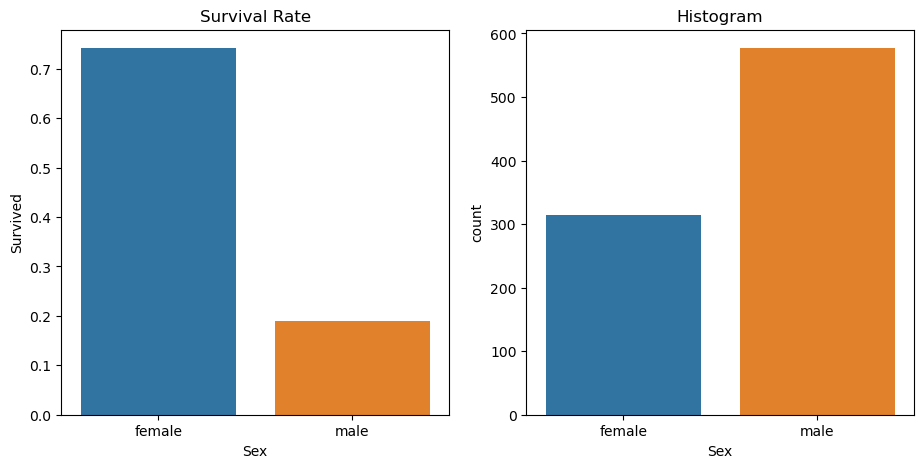

In [15]:
import seaborn as sns
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
sns.barplot(data=df, x="Sex", y=dep, ax=axs[0], errorbar=("ci", 0)).set(title="Survival Rate");
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

In [24]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
trn_df, val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [25]:
def xs_y(df):
    xs = df[cats+conts].copy()
    y = df[dep]
    return xs, y

trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)

In [26]:
preds = val_xs.Sex == 0

In [27]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.21524663677130046

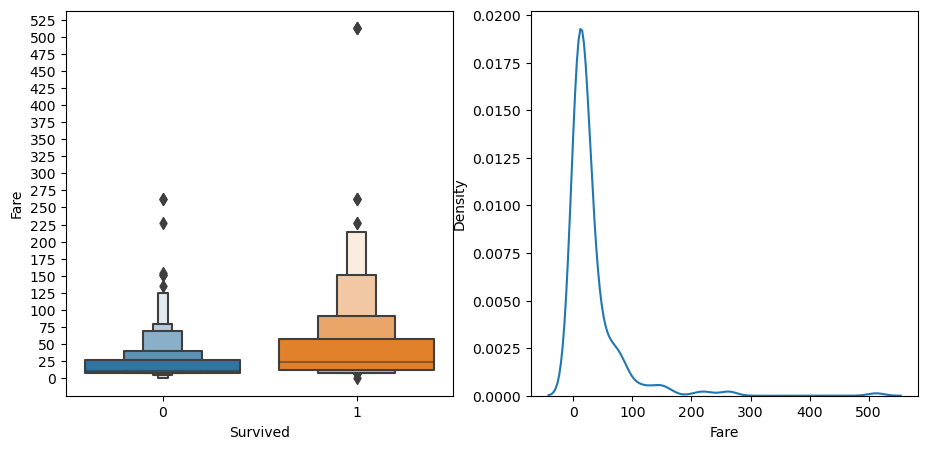

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
axs[0].yaxis.set_ticks(range(0, 550, 25))
sns.boxenplot(data=trn_df, x=dep, y="Fare", ax=axs[0]);
sns.kdeplot(data=trn_df, x="Fare", ax=axs[1]);

In [30]:
trn_df[trn_df.Survived == 0].Fare.median(), trn_df[trn_df.Survived == 1].Fare.median()

(10.5, 24.0)

In [33]:
preds = val_xs.Fare > 17.25

In [34]:
mean_absolute_error(val_y, preds)

0.3183856502242152

In [40]:
def _side_score(side, y):
    tot = side.sum()
    if tot <= 1: return 0
    return y[side].std()*tot

def score(col, y, split):
    lhs = col <= split
    return (_side_score(lhs, y) + _side_score(~lhs, y)) / len(y)

In [42]:
score(trn_xs["Sex"], trn_y, 0.5)

0.40787530982063946

In [43]:
score(trn_xs["Fare"], trn_y, 17.25)

0.4708826537124723

In [45]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'Fare', 'Pclass'), value='A…

In [48]:
interact(nm=cats, split=2)(iscore);

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=2,…

In [49]:
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,
        5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  , 13.  ,
       14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  ,
       22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  , 28.  , 28.5 ,
       29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  ,
       36.  , 36.5 , 37.  , 38.  , 39.  , 40.  , 40.5 , 41.  , 42.  ,
       43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  ,
       51.  , 52.  , 53.  , 54.  , 55.  , 55.5 , 56.  , 57.  , 58.  ,
       59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  ,
       80.  ])

In [52]:
scores = np.array([score(col, trn_y, o) for o in unq])
unq[scores.argmin()]

6.0

In [54]:
def min_col(df, nm):
    col, y = df[nm], df[dep]
    unq = col.unique()
    scores = np.array([score(col, y, o) for o in unq])
    idx = scores.argmin()
    return unq[idx], scores[idx]

min_col(trn_df, "Age")

(6.0, 0.478316717508991)

In [55]:
cols = cats + conts
{o: min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.40787530982063946),
 'Embarked': (0, 0.47883342573147836),
 'Age': (6.0, 0.478316717508991),
 'SibSp': (4, 0.4783740258817434),
 'Parch': (0, 0.4805296527841601),
 'Fare': (10.4625, 0.4620823937736597),
 'Pclass': (2, 0.46048261885806596)}

In [56]:
cols.remove("Sex")
ismale = trn_df.Sex == 1
males, females = trn_df[ismale], trn_df[~ismale]

In [57]:
{o: min_col(males, o) for o in cols}

{'Embarked': (0, 0.3875581870410906),
 'Age': (6.0, 0.3739828371010595),
 'SibSp': (4, 0.3875864227586273),
 'Parch': (0, 0.3874704821461959),
 'Fare': (15.5, 0.3804856231758151),
 'Pclass': (1, 0.38155442004360934)}

In [58]:
{o: min_col(females, o) for o in cols}

{'Embarked': (0, 0.4295252982857327),
 'Age': (50.0, 0.4225927658431649),
 'SibSp': (4, 0.42319212059713535),
 'Parch': (3, 0.4193314500446158),
 'Fare': (69.55, 0.41350598332911376),
 'Pclass': (2, 0.3335388911567601)}

In [59]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [60]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

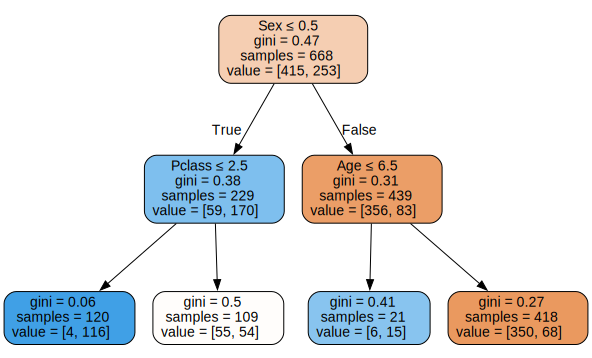

In [61]:
draw_tree(m, trn_xs, size=10)

In [62]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1.0 - act.mean()**2 - (1 - act).mean()**2

In [63]:
gini(df.Sex == "female"), gini(df.Sex == "male")

(0.3828350034484158, 0.3064437162277842)

In [64]:
mean_absolute_error(val_y, m.predict(val_xs))

0.2242152466367713

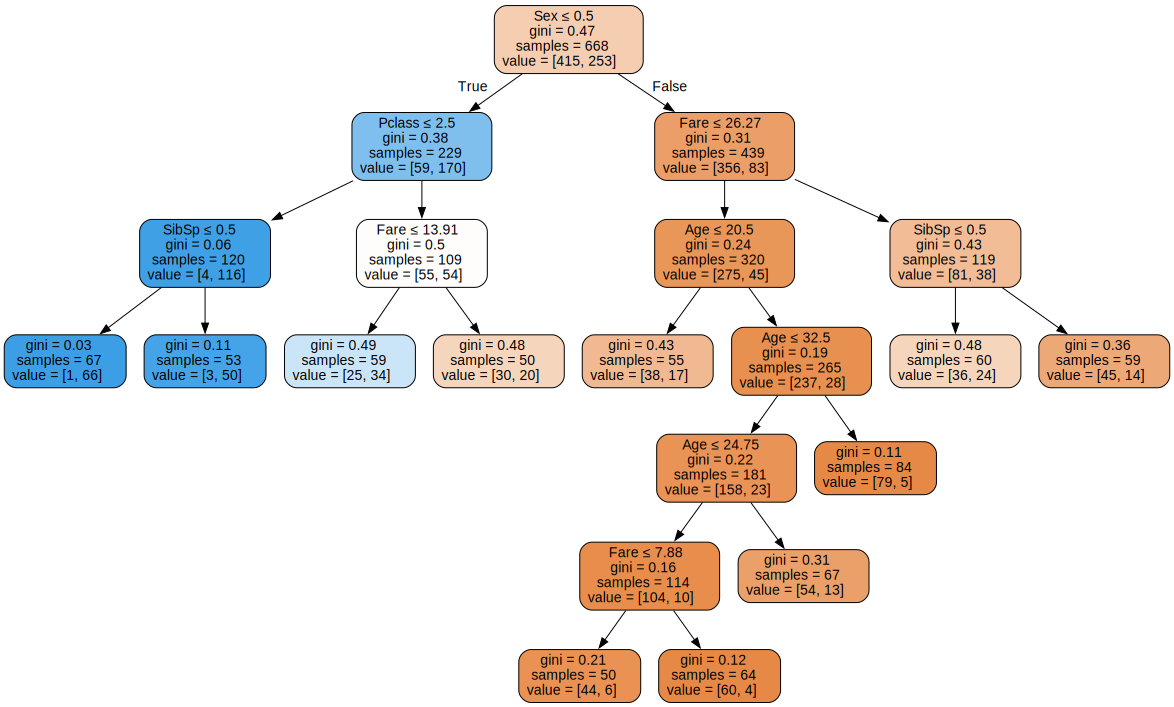

In [66]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=25)

In [68]:
mean_absolute_error(val_y, m.predict(val_xs))

0.18385650224215247

In [69]:
df.Embarked.head(), df.Embarked.cat.codes.head()

(0    S
 1    C
 2    S
 3    S
 4    S
 Name: Embarked, dtype: category
 Categories (3, object): ['C', 'Q', 'S'],
 0    2
 1    0
 2    2
 3    2
 4    2
 dtype: int8)

In [95]:
cols = np.array(cats + conts)

def get_tree(prop=0.75, cols_prop=1.0):
    c = len(cols)
    col_idxs = np.random.choice(c, int(cols_prop*c))
    cs = cols[col_idxs]
    trn_xs_sub = trn_xs[cs]

    n = len(trn_y)
    idxs = np.random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs_sub.iloc[idxs], trn_y.iloc[idxs]), cs

In [138]:
trees = [get_tree(0.75, 0.6) for t in range(500)]

In [139]:
all_probs = [t.predict(val_xs[cs]) for t, cs in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.28602690582959645

<Axes: ylabel='cols'>

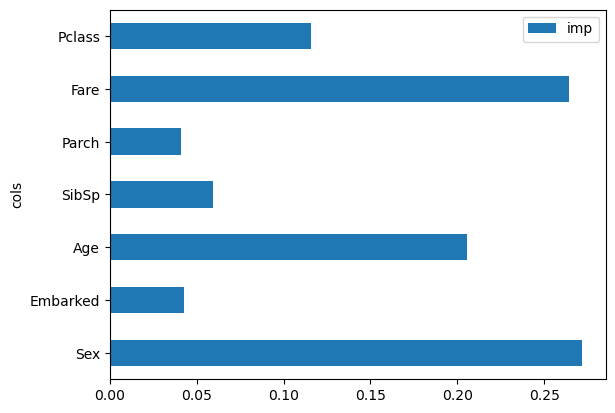

In [140]:
df = {c: 0.0 for c in cols}
for t, cs in trees:
    for ci in range(len(cs)):
        df[cs[ci]] += t.feature_importances_[ci]
df = {k: v/len(trees) for k, v in df.items()}
pd.DataFrame(dict(cols=df.keys(), imp=df.values())).plot("cols", "imp", "barh")

In [136]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(500, min_samples_leaf=5)
rf.fit(trn_xs, trn_y)
mean_absolute_error(val_y, rf.predict(val_xs))

0.18834080717488788

<Axes: ylabel='cols'>

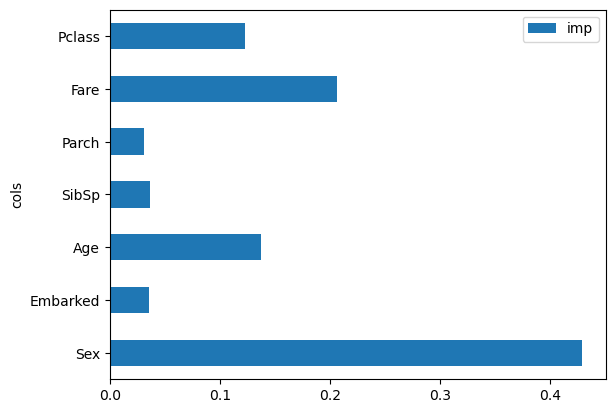

In [137]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=rf.feature_importances_)).plot("cols", "imp", "barh")